In [ ]:
!pip install git+https://github.com/nottombrown/imagenet_stubs

In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

# # Load Imagenet Stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [ ]:
resnet = ResNet50(weights='imagenet')

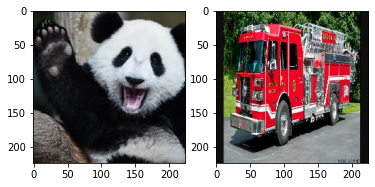

In [ ]:
img_path = tf.keras.utils.get_file('Panda', origin= 'https://pbs.twimg.com/profile_images/829274786362699776/a1ttXfVG.jpg')

img_1 = image.load_img(img_path, target_size=(224, 224))
x_img_1 = image.img_to_array(img_1)
x_img_1 = np.expand_dims(x_img_1, axis=0)

img_path = tf.keras.utils.get_file('Fire Truck', origin= 'https://bloximages.chicago2.vip.townnews.com/poststar.com/content/tncms/assets/v3/editorial/0/8f/08f0b7c6-3c09-52e1-931e-b77d0b0aa3ad/5a733112d2d0f.image.jpg?resize=1200%2C494')
img_2 = image.load_img(img_path, target_size=(224, 224))
x_img_2 = image.img_to_array(img_2)
x_img_2 = np.expand_dims(x_img_2, axis=0)



x_img = np.vstack((x_img_1, x_img_2))

f = plt.figure()
ax1 = f.add_subplot(1,2,1)
ax1.imshow(img_1)
ax2 = f.add_subplot(1,2,2)
ax2.imshow(img_2)

In [ ]:
pred = resnet.predict(x_img)
labels = np.argmax(pred, axis=1)

for i in range(labels.shape[0]):
  label = labels[i]
  confidence = pred[:,label][i]
  print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 1.00
Prediction: fire engine, fire truck - confidence 0.61


In [ ]:
# My Implementation
def deep_fool_attack(model, input_img_batch, num_classes=10, overshoot=0.02, max_itr=50):

  # getting top 10 labels of each image in the batch and storing it as numpy array
  f_batch = model(input_img_batch).numpy()
  f_batch_labels = np.argsort(-f_batch)[:,:num_classes]
  labels = f_batch_labels[:, :1].flatten()

  # Copy input image and initialize w and r
  input_shape = input_img_batch.shape
  pert_image_batch = copy.deepcopy(input_img_batch)
  backup = copy.deepcopy(input_img_batch)
  w = np.zeros(input_shape)
  r_tot = np.zeros(input_shape)

  noise = np.zeros(input_shape)

  i, itr = 0, 0
  k = labels.copy()
  

  def loss_func(logits, I, k):
    return logits[0, I[k]]

  # Start loop for each image and change its label
  while i < input_shape[0]:
    x = tf.Variable(backup[i])
    while k[i] == labels[i] and itr < max_itr:
      x = tf.expand_dims(x, axis=0)

      pert = np.inf
      with tf.GradientTape() as tape:
        tape.watch(x)
        fs = model(x)
        loss_value = loss_func(fs, f_batch_labels[i], 0)
      
      grad_orig = tape.gradient(loss_value, x)

      for j in range(1, num_classes):
        
        with tf.GradientTape() as tape:
          tape.watch(x)
          fs = model(x)
          loss_value = loss_func(fs, f_batch_labels[i], j)
        curr_grad = tape.gradient(loss_value, x)
        
        w_k = curr_grad - grad_orig
        f_k = (fs[0, f_batch_labels[i][j]] - fs[0, f_batch_labels[i][0]]).numpy()
        pert_k = abs(f_k) / np.linalg.norm(tf.reshape(w_k, [-1]))

        if pert_k < pert:
          pert = pert_k
          w[i] = w_k

      r_i = (pert + 1e-4) * w[i] / np.linalg.norm(w[i])

      r_tot[i] = np.float32(r_tot[i] + r_i)
      pert_image_batch[i] = input_img_batch[i] + (1 + overshoot) * r_tot[i]

      x = tf.Variable(pert_image_batch[i])
      noise[i] = (1 + overshoot) * r_tot[i]
      fs = model(tf.expand_dims(x, axis=0))
      k[i] = np.argmax(np.array(fs).flatten())
      itr += 1
    r_tot[i] = (1 + overshoot) * r_tot[i]
    i += 1

  return pert_image_batch, noise



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


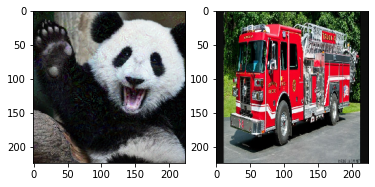

In [ ]:
df, noise = deep_fool_attack(resnet, x_img)

f = plt.figure()
ax1 = f.add_subplot(1,2,1)
ax1.imshow(df[0]/255)
ax2 = f.add_subplot(1,2,2)
ax2.imshow(df[1]/255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


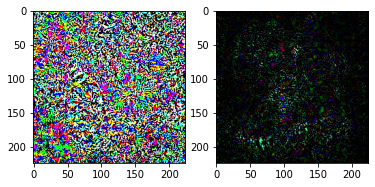

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(1,2,1)
ax1.imshow(noise[0])
ax2 = f.add_subplot(1,2,2)
ax2.imshow(noise[1])

In [ ]:
pred = resnet.predict(df)
labels = np.argmax(pred, axis=1)

for i in range(labels.shape[0]):
  label = labels[i]
  confidence = pred[:,label][i]
  print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: indri, indris, Indri indri, Indri brevicaudatus - confidence 0.63
Prediction: garbage truck, dustcart - confidence 0.17
